<a href="https://colab.research.google.com/github/gagan3012/ML-hackathons/blob/master/notebooks/Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [Datasets](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!nvidia-smi

Mon Jun 21 06:28:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [4]:
# load into a data frame
df1 = pd.read_csv('https://raw.githubusercontent.com/adigoryl/Styled-Lyrics-Generator-GPT2/master/datasets/genius_lyrics_v2.csv',header=None)
df1.columns = ['type','artist','year','album','track','lyrics']  
df = df1.head(1000)
df

,type,artist,year,album,track,lyrics
0,Pop,Justin Bieber,2015,Purpose,Love Yourself,For all the times that you rained on my parade...
1,Pop,Justin Bieber,2015,Purpose,Sorry,You gotta go and get angry at all of my honest...
2,Pop,Justin Bieber,2012,Believe,As Long As You Love Me,As long as you love me\nAs long as you love me...
3,Pop,Justin Bieber,2015,Purpose,What Do You Mean?,"What do you mean? Oh, oh\nWhen you nod your he..."
4,Pop,Justin Bieber,2010,My World 2.0,Baby,"Oh, woah\nOh, woah\nOh, woah\n\nYou know you l..."
...,...,...,...,...,...,...
995,Pop,Beyoncé,2013,BEYONCÉ,Heaven,"I fought for you\nThe hardest, it made me the ..."
996,Pop,Beyoncé,2016,Lemonade,Daddy Lessons,"Yee-haw\nOoh\nTexas, Texas (Ooh) Texas\n\nCame..."
997,Pop,Beyoncé,2011,4,Countdown,"Boy!\n\nOh, killing me softly and I'm still fa..."
998,Pop,Beyoncé,2016,Lemonade,Forward,Forward\nBest foot first just in case\nWhen we...


In [5]:
df.dropna(inplace=True) #remove NA values
bios = df.lyrics.copy() #just use the main bio text in this example
bios

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0      For all the times that you rained on my parade...
1      You gotta go and get angry at all of my honest...
2      As long as you love me\nAs long as you love me...
3      What do you mean? Oh, oh\nWhen you nod your he...
4      Oh, woah\nOh, woah\nOh, woah\n\nYou know you l...
                             ...                        
995    I fought for you\nThe hardest, it made me the ...
996    Yee-haw\nOoh\nTexas, Texas (Ooh) Texas\n\nCame...
997    Boy!\n\nOh, killing me softly and I'm still fa...
998    Forward\nBest foot first just in case\nWhen we...
999    Yes! So crazy right now!\nMost incredibly, it'...
Name: lyrics, Length: 999, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


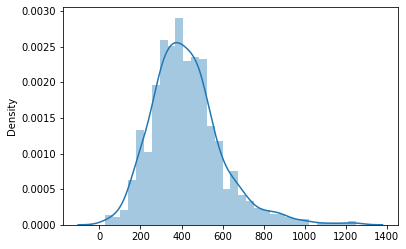

In [6]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [7]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.042042042042042045

In [8]:
np.average(doc_lengths)

424.55055055055055

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [9]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [11]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [12]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [13]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  899 training samples
  100 validation samples


In [14]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [15]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [16]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [18]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [19]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [20]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 2.029113531112671.   Elapsed: 0:00:58.
0:  bipartisan", where I live, where I

And where I'm from, where I'm from, where I'm from
And where I'm from

Hate on that side
And how much I hate you
It feels like it always hurts
Ooh so good
And how much I hate you

It feels like it always hurts
Ooh so good
And how much I hate you
It feels like it always hurts
Ooh so good
And how much I hate you

You
I hate myself
Cause so good
Cause so bad

And how much I hate you
Cause so good

Cause so bad
Cause so hard
I love myself
Cause so good
Cause so bad
Cause so hard
I love myself
Cause so bad
Cause so hard
Cause so easy
Cause so good
Cause so easy

Cause so easy
Cause so hard



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.8680258989334106.   Elapsed: 0:01:57.
0:  increasing

Halo, now
(If you want to know what I've been doing to you)

Halo-ta-la, now

You just had one more chance

Halo-ta-la, now (Hey, no)
Halo-ta-la, now (Hey, no)

Halo-ta-la, now (Hey, no)



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 1.7209851741790771.   Elapsed: 0:02:55.
0: dayAnd a thousand miles of rivers and stars and my own sky…

We'll break out of your head and the stars are spinning around us
Don't go through my head"
Oh I'll be the one you're always dreaming of
To be the one who never goes out, so you can never find a way
I'll be the one you always dream of
To be the one you always dream of

And all you have to do is give up
And I'll be the one you always dream of
To be the one you always dream of

I will be the one you always dream of
To be the one you always dream of

(Like this post)

Do you have one of those, huh
Oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh
Oh baby, how are


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.0475828647613525.   Elapsed: 0:03:55.
0:  HangI think you need me when you're hurting, just take it away
Don't leave me alone
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth

Don't give you what you're worth
Don't give you what you're worth
Don't give you what you're worth

  Average training loss: 2.08
  Training epoch took: 0:04:25

Running Validation...
  Validation Loss: 1.22
  Validation took: 0:00:10

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 1.4023469686508179.   Elapsed: 0:00:57.
0:  foodsI don't know the world
A lot of people say that we all
Wish we'd never found
A way we've found

'Cause this is a mess
'Cause everybody can forget about you

'Cause I know we went crazy
We had no choice

"Oh, ooh, you're gone
Ah, it's so bittersweet
It's so bittersweet
It's so bittersweet
Oh
"So, uh, now I gotta see

And I know that I can't stop

"Oh, ooh, you're gone
Ah, it's so bittersweet
It's so bittersweet
It's so bittersweet
It's so bittersweet
It's so bittersweet
Oh
"Oh, ooh, you're gone
Ah, it's so bittersweet
It's so bittersweet
Oh

"Oh, ooh, you're gone
Ah, it's so


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.9119707345962524.   Elapsed: 0:01:57.
0:  trailOh, that one was bad, but that one was alright
I should've known better
Oh, that one was bad
Oh, that one was bad
Oh, that one was bad

Hey, look at me!
I'm the one I've tried to break down
You don’t have to worry that I’ll fall
Look how hard you pushed me through
Don’t have to worry that I’ll break down
Don’t have to worry that I’ll break down
Ohh, that one was good, but that one was better
Ohh, that one was bad, but that one was better
Ohh, that one was bad
Ohh
Ohh


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 1.8577890396118164.   Elapsed: 0:02:56.
0: intendOh, yeah, yeah
Yeah, yeah, yeah

Yeah, yeah, yeah, yeah

Yeah, yeah, yeah yeah

Yeah, yeah, yeah yeah
Yeah, yeah, yeah yeah
Yeah, yeah, yeah yeah

Yes, yeah, yeah, yeah yeah
Yeah, yeah, yeah yeah
Yeah, yeah, yeah yeah

Yeah, yeah, yeah yeah
Yeah, yeah, yeah yeah
Yeah, yeah, yeah
Yep, yeah, yeah yeah
Yeah, yeah, yeah yeah
Yeah, yeah, yeah yeah
Yep, yeah, yeah yeah
Yep, yeah, yeah yeah
Yeah, yeah, yeah yeah

Yes, yeah, yeah, yeah
Yeah, yeah, yeah yeah
Yeah, yeah, yeah yeah


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.6972118616104126.   Elapsed: 0:03:55.
0:  surroundTired of being down on my knees with nothing to lose
When your mind's on me, all that I wanna do is leave
It's sad when it's lost, in this moment
I love what you do to me, darling
I don't know what I could have said, but I'm gonna leave this for a little

Oh, and you know I don't really care what you do to me
You know I love what you do to me, darling
I don't know what I could have said, but I'm gonna leave this for a little

Oh, and you know I don't really care what you do to me
You know I love what you do to me, darling
I don't know what I could have said, but I'm gonna leave this for a little

Oh, and you know I don't really care what you do to me
You know I love what you do to me, darling
I don

  Average training loss: 1.22
  Training epoch took: 0:04:25

Running Validation...
  Validation Loss: 1.20
  Validation took: 0:00:10

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 1.0745365619659424.   Elapsed: 0:00:58.
0:  reflexA moment later a tear stream in through the rain
Just as we were leaving
We passed it off as nothing and a moment later we were
Walking with someone like you
Who makes you look down upon the sky and look up into the night?
Just as we were leaving
We passed it off as nothing and a moment later we were
Walking with someone like you
Who makes you look down upon the sky and look up into the night?
Just as we were leaving

There it is... there it is...

Oh Lord, there it is...

This is my home now, my home
I'll never let you in it again
There is no one else in this room
Where the words are left out
'Cause I’ve never been
And I’m yours to call

I'll never let you in it again
There is no one else in this room
Where the words are left out



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 1.2086268663406372.   Elapsed: 0:01:57.
0:  displayI love the way you make me feel
I love how you make me feel
I love how you make me feel
I love how you make me feel

I love the way you make me feel
I love the way you make me feel

I love the way you make me feel
I love the way you make me feel

I love the way you make me feel
I love the way you make me feel

I love the way you make me feel
I love the way you make me feel
I love the way you make me feel

I love the way you make me feel

I love the way you make me feel
I love the way you make me feel

I love the way you make me feel
I love the way you make me feel

I love the way you make me feel
I love the way you make me feel
I love the way you make me feel
I love the way you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 2.3404998779296875.   Elapsed: 0:02:57.
0:  pastorWe've been through a lot, yeah
I've spent more of my life with you
Like the rest of your kind and not afraid to say no to you, yeah
You've been my baby, too

Don't let you go, I'll take you there
I'll take you there too (We'll take you there)
I'll take you there too
I'll take you there
I will take you there

No, I won't make you afraid
You're a good girl, I'm strong and I can take it, yeah
You've been my baby, too

Don't let you go, I'll take you there
I'll take you there
I'll take you there
I will take you there
I will take you there
I will take you there

Don't let you go, I'll take you there
I'll take you there
I'll take you there
I will take you there



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.4127885103225708.   Elapsed: 0:03:56.
0:  illicitI like it when they say they want me now
But I don't know what to do now
So tell me, boy, what you gonna do?
I've done too much
And you've made too many mistakes
And you've been so mean
I'm so sorry

Oh I got you feeling so different today
I'm so sorry
I got you feeling so different now
I'm so sorry

Oh I got you feeling so different today
I'm so sorry
I got you feeling so different today
I'm so sorry

I got you feeling so different today
I'm so sorry
I got you feeling so different today
I'm so sorry
I got you feeling so different today
Oh, it's just a little different today
Oh, it's just a little different

Hey, I got it now, baby
I got it right now

I got you feeling so different now
I'm so sorry


  Average training loss: 1.13
  Training epoch took: 0:04:26

Running Validation...
  Validation Loss: 1.20
  Validation took: 0:00:10

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 1.3854124546051025.   Elapsed: 0:00:58.
0:  LiberationI said to myself "Oh, girl, this is stupid, you're so stupid" (Oh no, no, no) I said I'ma make a toast
But I never ever ever said anything, never ever ever said to me
You know what I'm thinkin' right now?
There ain't no words, no more words
But you can say anything you wanna, you know what I mean
I swear, it's already been said

And I got a dream to make my dreams come true
I wanna make my dreams come true
I wanna make my dreams come true
But girl, you just can't control, so you gotta have some
So let's just say that I'll never give up (Let's just say that I'll never give up)

So, say that you'll never take my love away

And I got a dream to make my dreams come true
I wanna make my dreams come true
And I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.935236394405365.   Elapsed: 0:01:57.
0:  NamI'm gonna take it all
You're beautiful but I'm flawed
I'm gonna pull you out of me
I don't want you in my life but I don't want you to be
The one thing I love, like you are
You're in my life but you're in my world
You're never gonna disappear in my world

I'm gonna take it all
You're beautiful but I'm flawed
I'm gonna pull you out of me
I don't want you in my life but I don't want you to be
The one thing I love, like you are
You're in my life but you're in my world
You're never gonna disappear in my world

I'm gonna take it all
You're beautiful but I'm flawed
I'm gonna pull you out of me
I don't want you in my life but I don't want you to be
The one thing I love, like you are
You're


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 1.1750648021697998.   Elapsed: 0:02:57.
0: IONThe world belongs to me

I'm a product of my own creation
I'm the product of my own design
I can make any choice that you want

I'm a product of your love
I'm the product of your persuasion
I can make any choice that you want

The way that you smile is a reflection of my true colors
A reflection of me
You and my world is what makes us free
You and your love is the truth that has been shed

We are the product of your love
We are the product of your freedom
We are the products of your love

Let me lay down my life
Let me show you how

All that I do is to live
Let me tell you how

That's the way that you smile is a reflection of my true colors
A reflection of me
You and my world is what makes us free
You and your love is the truth that has been shed




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 1.3809524774551392.   Elapsed: 0:03:56.
0:  glimpseIt felt like daylight
I walked up to you and took it all in my mind
And there was nothing that I could say
That it wouldn't sink in, no, you wouldn't leave
No, you wouldn't stay
No, you wouldn't stay
Oh it's no good for you

You make me question your intentions
And you're the only one I care to call
But if you're really that lonely, I bet it's not you
You're the only one I care to call
But if you're really that lonely, I bet it's not you

It's no good for you

You make me question your intentions
And you're the only one I care to call
But if you're really that lonely, I bet it's not you
You're the only one I care to call
But if you're really that lonely, I bet it's not you

It's no good for you

I

  Average training loss: 1.05
  Training epoch took: 0:04:26

Running Validation...
  Validation Loss: 1.21
  Validation took: 0:00:10

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    450. Loss: 0.7431923747062683.   Elapsed: 0:00:58.
0:  LaureI've been away, and I need you there more
You've made my bed aching
And you're holding me tight, no, don't let me go, hey

You need a little clarity, I'm in too deep
You need to know we've got a lot in common
So, baby, let's get down from this
I'm feeling so obligated

I'm so used to this life, feel this touch
I don't wanna be here on your worst night

I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you and I don't need you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    450. Loss: 0.8593940734863281.   Elapsed: 0:01:57.
0: ismI met you a couple years ago
In a café in the middle of town
You said you liked being alone
But I didn't

And yet we made our way on the same old story
And we've grown old together
I've forgotten our chemistry
And even though it's pretty fun we are still friends

I'm not the only one in your circle
I see things we can't seem to forget
And I need you to keep me on the road
I'd risk everything to get you close
And if you don't want me
Just say so
It's only right, but you do what you need

But there you are, still, still in love
Still in love, still in love
And there you are, still, still in love

And I know that I've been through too much
And maybe I'm alone
So I hope you and I make this a little more than we've ever been before



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    450. Loss: 0.8938676714897156.   Elapsed: 0:02:57.
0: ounI'm taking too much time
I think we don't have the time to waste
Maybe it's time I get a little obsessive
Maybe it's time I get a little fickle
Maybe it's time I let it all get hard on myself
Maybe it's time I get a little obsessive
Maybe it's time I get a little fickle
Maybe it's time I get a little fickle
Maybe it's time I get a little fickle
Maybe it's time I get a little fickle

There’s room and I don’t know where to start
I hope your story is one that gets across my heart
Cause that’s what makes me who I am

Ooh, I can’t wait another minute
But at least we could get down to business
I guess it’s time we could get a little obsessive
Maybe it’s time I get a little fickle
Maybe it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    450. Loss: 0.8278471231460571.   Elapsed: 0:03:56.
0:  electionLamborghinis, Lamborghinis
Lamborghinis, Lamborghinis

Sessions, sedans, sedans
Lamborghinis, Lamborghinis

Mulsanne, mulsanne
Sessions, sedans, sedans
Lamborghinis, Lamborghinis

Bikes on the side of the roadway
Mulsanne, mulsanne
Sessions, sedans, sedans

(Catch 'em where you are)
Sessions, sedans, sedans

Lamborghinis, Lamborghinis
Sessions, sedans, sedans

Ooh, my, my

You know I don’t ever see myself quite the same way

Lamborghinis, Lamborghinis

And I still love that Bugatti
I still love that Bugatti
But I still want a Lamborghini
I always want a Lamborghini
I always

  Average training loss: 0.98
  Training epoch took: 0:04:26

Running Validation...
  Validation Loss: 1.23
  Validation took: 0:00:10

Training complete!
Total training took 0:22:56 (h:mm:ss)


Let's view the summary of the training process.

In [21]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.08,1.22,0:04:25,0:00:10
2,1.22,1.20,0:04:25,0:00:10
3,1.13,1.20,0:04:26,0:00:10
4,1.05,1.21,0:04:26,0:00:10
5,0.98,1.23,0:04:26,0:00:10


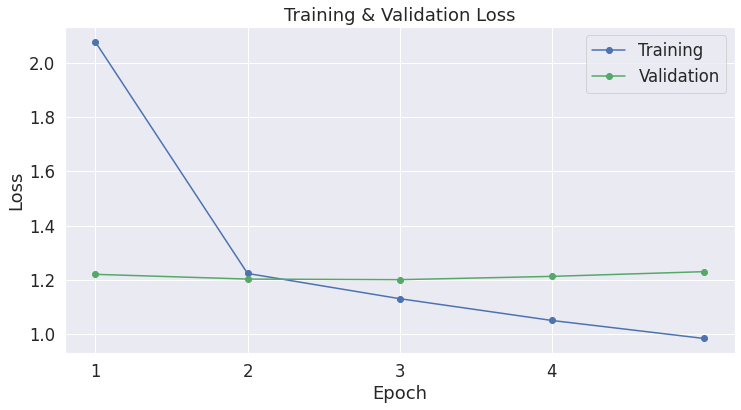

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [24]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [25]:
!ls -l --block-size=K ./model_save/

total 499792K
-rw-r--r-- 1 root root      1K Jun 21 06:52 added_tokens.json
-rw-r--r-- 1 root root      1K Jun 21 06:52 config.json
-rw-r--r-- 1 root root    446K Jun 21 06:52 merges.txt
-rw-r--r-- 1 root root 498448K Jun 21 06:52 pytorch_model.bin
-rw-r--r-- 1 root root      1K Jun 21 06:52 special_tokens_map.json
-rw-r--r-- 1 root root      1K Jun 21 06:52 tokenizer_config.json
-rw-r--r-- 1 root root    878K Jun 21 06:52 vocab.json


In [26]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Jun 21 06:52 ./model_save/pytorch_model.bin


# Generate Text

In [28]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=1
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: The night's the last of me, it was a life changing night
I woke up to the taste of her perfume in my face
I spent my last breath taking deep breath
She was the one to call, 'cause her name on the credits
She gave me back a world I wouldn't change
Even her friends were saying the least
How we used to laugh when I'm in the clouds

She wasn't my baby, not ever
Even when she was my lover
She was the only thing I wanted
I'd stand by her side
In the rain, the stars came alive
In the waves and the silence
It was the summer air
It was the night that I was dreaming about

Her body language's whisper
Shakin', whisper, whisper
She said, "Never, never, never
Even when we're together
Never, never
"Oh," the night turned into a day
And the nights turned into days

It was the summer air
It was the night that I was dreaming about
(It was the summer air)
It was the night that I was dreaming about

She wasn't my baby, not ever
Even when she was my lover
She was the o